2.0.0-alpha0
(5923, 28, 28)
(60000,)
(980, 28, 28)
(10000,)


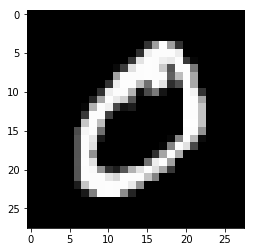

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# double check your tf version
print(tf.__version__)

# get sampling data set
fashion_mnist = keras.datasets.mnist
(trainx, trainy), (testx, testy) = fashion_mnist.load_data()

trainx = trainx[trainy == 0]
testx = testx[testy == 0]

import matplotlib.pyplot as plt
imgplot = plt.imshow(trainx[0], cmap='gray')

print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)

There were 2 part in GAN : Generator and Discriminator.
here is the algorithm:
1. fix Generator's parameter and generate randomly sample vector output.
2. get real sample from DB
3. Train Discriminator with real sample + bad sample
4. fix Discriminator's parameter and train Generator.

https://ithelp.ithome.com.tw/articles/10208478?sc=iThelpR

https://medium.com/@gau820827/教電腦畫畫-初心者的生成式對抗網路-gan-入門筆記-tensorflow-python3-dfad71662952

In [22]:
class myGAN():
    def __init__(self, width=28, height=28, channels=1):
        self.width = width
        self.height = height
        self.channels = channels
        self.shape = (self.width, self.height, self.channels)
        self.optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.GAN = self.__gan()
        self.GAN.compile(loss='binary_crossentropy', optimizer=self.optimizer)        
      
    # use vector as input.
    def __generator(self):
        model = tf.keras.Sequential(
            [
                # layer 1
                tf.keras.layers.Dense(256, input_shape=(100,)),
                tf.keras.layers.LeakyReLU(alpha=0.2),   # 使用 LeakyReLU 激活函數
                tf.keras.layers.BatchNormalization(momentum=0.8),  # 使用 BatchNormalization 優化
                
                # layer 2
                tf.keras.layers.Dense(512),
                tf.keras.layers.LeakyReLU(alpha=0.2),
                tf.keras.layers.BatchNormalization(momentum=0.8),
                                
                # layer 3
                tf.keras.layers.Dense(1024),
                tf.keras.layers.LeakyReLU(alpha=0.2),
                tf.keras.layers.BatchNormalization(momentum=0.8),
                
                # convenlution layer
                tf.keras.layers.Dense(self.width  * self.height * self.channels, activation='tanh'),
                #model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
                tf.keras.layers.Reshape((self.width, self.height, self.channels))                
            ]
        )
        model.summary()
        return model
    
    def __discriminator(self):
        model = tf.keras.Sequential( 
            [
                tf.keras.layers.Flatten(input_shape=self.shape),

                tf.keras.layers.Dense((self.width * self.height * self.channels), input_shape=self.shape),
                tf.keras.layers.LeakyReLU(alpha=0.2),

                tf.keras.layers.Dense(int((self.width * self.height * self.channels)/2)),
                tf.keras.layers.LeakyReLU(alpha=0.2),

                tf.keras.layers.Dense(1, activation='sigmoid')
            ]
        )
        model.summary()
        return model
    
    def __gan(self):
        self.D.trainable = False
        self.G.trainable = True

        model = tf.keras.Sequential(
            [
                self.G,
                self.D
            ]
        )

        return model
    
    # 1. fix Generator's parameter and generate randomly sample vector output.
    # 2. get real sample from DB
    # 3. Train Discriminator with real sample + bad sample
    # 4. fix Discriminator's parameter and train Generator.

    def train(self, X_train, epochs=10000, batch = 32, save_interval = 100):

        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train))  # len(X_train) - batch/2
            legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (int(batch/2), 100)) 
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))  # 添加高斯噪聲
            y_mislabled = np.ones((batch, 1))

            g_loss = self.GAN.train_on_batch(noise, y_mislabled)

            print('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)
                
    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        filename = "./Result/gan_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [23]:
go = myGAN()
go.train(trainx)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_v2_24 (B (None, 256)               1024      
_________________________________________________________________
dense_54 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_v2_25 (B (None, 512)               2048      
_________________________________________________________________
dense_55 (Dense)             (None, 1024)            

W0808 23:27:38.852127  5400 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


epoch: 0, [Discriminator :: d_loss: 51.442188], [ Generator :: loss: 0.754501]
epoch: 1, [Discriminator :: d_loss: 4.056028], [ Generator :: loss: 0.689249]
epoch: 2, [Discriminator :: d_loss: 0.343324], [ Generator :: loss: 0.627051]
epoch: 3, [Discriminator :: d_loss: 0.359982], [ Generator :: loss: 0.541141]
epoch: 4, [Discriminator :: d_loss: 0.397553], [ Generator :: loss: 0.516803]
epoch: 5, [Discriminator :: d_loss: 0.388021], [ Generator :: loss: 0.538756]
epoch: 6, [Discriminator :: d_loss: 0.459336], [ Generator :: loss: 0.471429]
epoch: 7, [Discriminator :: d_loss: 0.446728], [ Generator :: loss: 0.458804]
epoch: 8, [Discriminator :: d_loss: 0.470265], [ Generator :: loss: 0.437638]
epoch: 9, [Discriminator :: d_loss: 0.456384], [ Generator :: loss: 0.454545]
epoch: 10, [Discriminator :: d_loss: 0.477156], [ Generator :: loss: 0.475541]
epoch: 11, [Discriminator :: d_loss: 0.533526], [ Generator :: loss: 0.427837]
epoch: 12, [Discriminator :: d_loss: 0.551914], [ Generator :

In [24]:
import jovian
jovian.commit()